# Import Python Modules

In [79]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

## Approach
In the R files, both regression and tree models were considered, and the best model found so-far was a regression model.  The tree model with the lowest cross-validation error on the training data did not perform nearly as well, but used only two variables.  Here both methods are combined into an ensemble.

# Read in Data
Some initial preprocessing was done in the R files:
* Replaced blanks with NAs (NaN in df below)
* Moved the reponse variable (revenue) to the first field
* Replaced some outliers with NAs

In [2]:
df = pd.read_csv('dataCleanNoOutlier.csv')
# Drop the Week column, same info is captured in weekno
df = df.drop('Week', 1)
df.head()

,revenue,weekno,highseason,holiday,displayimp,displaylag,brandpaid,brandclicks,nonbrandpaid,nonbrandclicks,...,logSocialpostlag,organicnew2,logOrganicnew,blognewusers2,blognewusersRecip,Fbpostimplag2,weekOfYear2,sinWeekOfYear,Twpostimp2,logTwpostimp
0,178480,1,1,0,987718,983958.0000,31589,4715,105901,1519,...,198063.75,574369156,10.084391,3717184,0.000519,23343103440,25,0.822984,2245432996,10.766082
1,185390,2,1,0,660136,907388.9167,30428,4540,108652,1589,...,196355.00,600740100,10.106836,4137156,0.000492,21755266688,36,0.748511,8690900625,11.442771
2,178130,3,1,0,604606,852862.4167,30715,4417,119398,1595,...,194301.80,664144441,10.157005,10569001,0.000308,22414206939,49,0.663123,42966656656,12.241845
3,185020,4,1,0,560656,851885.3333,31632,4372,134819,1606,...,196355.00,679540624,10.168464,37601424,0.000163,21358244109,64,0.568065,4117917241,11.069307
4,170950,5,1,0,326112,827164.4167,NaN,4431,115865,1522,...,216089.00,581533225,10.090589,3069504,0.000571,NaN,81,0.464723,2996248644,10.910313


# Preprocessing
### Repeat Scaling in Python
As was done in R, variables are rescaled to be on the interval [0, 1]
(This is done primarily for the sake of having a clear sequence of steps to perform when testing new data)

In [3]:
def rescale(x):
    '''
    Rescale a vector x such that all values lie on the interval [0, 1]
    x: an np.array
    '''
    x = x - np.min(x)
    x = x / np.max(x)
    return x

# Test
x = np.array([4, 3, 9, 1, 7, 11])
rescale(x)

array([ 0.3,  0.2,  0.8,  0. ,  0.6,  1. ])

In [4]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

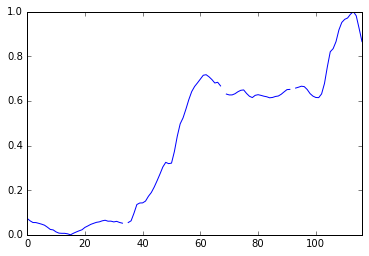

In [5]:
# Examine a column to verify that transformation was correct
df['displaylag'].plot();

### Normalizing Right-Skewed Distributions
The details of how these exponents were found are provided in `nuggetAnalysis3.R`

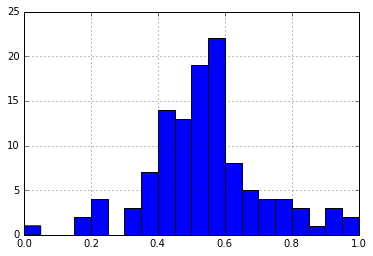

In [6]:
# Transform each of the following by their optimal exponential transform
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['socialpostimp'].hist(bins = 20);

In [7]:
df['socialpostimp'] = df['socialpostimp'] ** 0.29
df['Fbpostimp'] = df['Fbpostimp'] ** 0.33
df['Fbpostimplag'] = df['Fbpostimplag'] ** 0.29
df['Fblikes'] = df['Fblikes'] ** 0.60
df['Fbengage'] = df['Fbengage'] ** 0.44
df['Twpostimp'] = df['Twpostimp'] ** 0.29

Rescale again so new transformed values also distributed over [0, 1]:

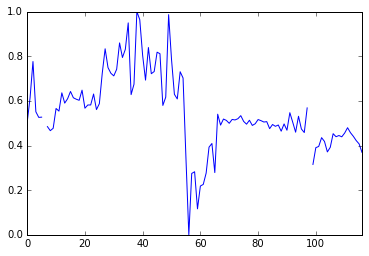

In [8]:
# Rescale all columns
df.ix[:, 2:59] = df.ix[:, 2:59].apply(rescale) 

# Verify
df['Twpostimp'].plot();

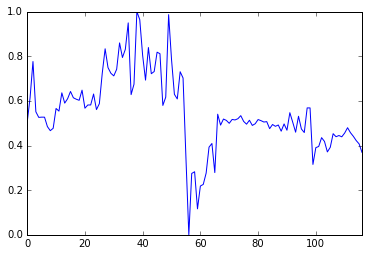

In [9]:
df.fillna(method = 'ffill', axis = 0, inplace = True)
df.fillna(method = 'bfill', axis = 0, inplace = True)
df['Twpostimp'].plot();

## Parse Data into Train and Test Sets

In [10]:
df.shape

(117, 57)

Hold out ~25% or 29 rows of data for the test set.

In [12]:
# Separate df into X (predictors) and y (response)
X = df.ix[:, 1:58]
y = df.ix[:, 0]

# Now split each into testing and training sets
# Ideally, we would stratify the data, but there are too few data in this
# sample 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 11)

In R, for the test set, we fill forward NaNs so they can be predicted using the models. The LinearRegression classifier in Python's sklearn module cannot handle missing data, so we fill for the training set as well.

# Linear Regression Models
Recreate the best linear model found in R, and explore further

In [13]:
lr_clf = LinearRegression()
modTr_lm2 = [
    'highseason', 'holiday', 'brandpaid', 'brandclicks', 'organicnew', 
    'youtube', 'youtubelag', 'socialpostlag', 'Fbengage', 'fbengagelag', 
    'TWimpLag', 'emailopen', 'blogvisits', 'blognewusers', 'blogsignup']
lr_clf.fit(X = X_train.ix[:, modTr_lm2], y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Compute RSS

NOTE: sklearn models had a `residues_` member, but it is deprecated, and will be removed in 0.19, so a function is provided here

In [14]:
def get_rss(mod, X, y):
    predictions = mod.predict(X)
    sq_error = [
        (pred - actual) ** 2 for (pred, actual) in zip(predictions, y)]
    RSS = sum(sq_error)
    
    return(RSS)

In [15]:
get_rss(lr_clf, X_test.ix[:, modTr_lm2], y = y_test)

7685302034.6259289

*Note that the value here of 7.6853e+9 differs slightly from the value found in R: 7.6168e+9 because we had to fill the NaN values for sklearn's LinearRegression classifier*

In [68]:
currentBest = { 
    'model': 'lr_clf',
    'rss': get_rss(lr_clf, X_test.ix[:, modTr_lm2], y = y_test) }

### Explore Ridge and Lasso Regression Further

In [36]:
pipe_ridge = Pipeline([('clf', Ridge(random_state = 11))])

In [62]:
alpha_range = np.linspace(0, 3, 30)
train_scores, test_scores = validation_curve(estimator = pipe_ridge,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 10,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

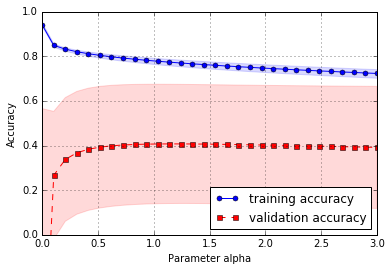

In [65]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training accuracy');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation accuracy');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
plt.legend(loc = 'lower right');
plt.xlabel('Parameter alpha');
plt.ylabel('Accuracy');
plt.ylim([0, 1.0]);
plt.show();

In [66]:
ridge_clf = Ridge(alpha = 0.9, random_state = 11)
ridge_clf.fit(X_train, y_train)
get_rss(ridge_clf, X_test, y_test)

5475076631.3099174

Compare to best so far:

In [69]:
currentBest

{'model': 'lr_clf', 'rss': 7685302034.6259289}

Update currentBest

In [74]:
currentBest = { 'model': 'ridge_clf',
                'rss': get_rss(ridge_clf, X_test, y_test) }

### Lasso Regression

In [83]:
pipe_lasso = Pipeline([(
            'clf', Lasso(random_state = 11, max_iter = 100000))])
alpha_range = np.linspace(1, 100, 30)
train_scores, test_scores = validation_curve(estimator = pipe_lasso,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__alpha',
                                             param_range = alpha_range,
                                             cv = 10,
                                             n_jobs = -1)
train_mean = np.mean(train_scores, axis = 1)
train_std  = np.std(train_scores,  axis = 1)
test_mean  = np.mean(test_scores,  axis = 1)
test_std   = np.std(test_scores,   axis = 1)

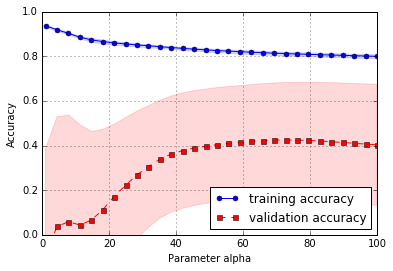

In [84]:
plt.plot(alpha_range,
         train_mean,
         color = 'blue',
         marker = 'o',
         markersize = 5,
         label = 'training accuracy');
plt.fill_between(alpha_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15,
                 color = 'blue');
plt.plot(alpha_range,
         test_mean,
         color = 'red',
         linestyle = '--',
         marker = 's',
         markersize = 5,
         label = 'validation accuracy');
plt.fill_between(alpha_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15,
                 color = 'red');
plt.grid();
#plt.xscale('log');
plt.legend(loc = 'lower right');
plt.xlabel('Parameter alpha');
plt.ylabel('Accuracy');
plt.ylim([0, 1.0]);
plt.show();

In [86]:
lasso_clf = Lasso(alpha = 70, random_state = 11)
lasso_clf.fit(X_train, y_train)
get_rss(lasso_clf, X_test, y_test)

5485779630.2985363

In [87]:
currentBest

{'model': 'ridge_clf', 'rss': 5475076631.3099174}

The ridge regession model is better, but only marginally.  Lasso is helpful in any case as it helps to determine which of the predictors are actually useful, as it drives those predictors' coefficients that are less useful to 0.  This is useful if we are trying to prioritize which predictors to continue to make use of or invest in.  To observe:

In [90]:
zip(df.columns.values, lasso_clf.coef_)
# Note: the first predictor is the intercept, not "revenue", the above 
# syntax is just a quick and dirty way to do this

[('revenue', -342.22190142270057),
 ('weekno', -0.0),
 ('highseason', -28128.807507657315),
 ('holiday', 0.0),
 ('displayimp', 47120.078556263492),
 ('displaylag', -0.0),
 ('brandpaid', 20856.884904594979),
 ('brandclicks', -0.0),
 ('nonbrandpaid', -6187.7987763952278),
 ('nonbrandclicks', 0.0),
 ('organicnew', 0.0),
 ('youtube', 6270.840242106884),
 ('youtubelag', 0.0),
 ('socialpostimp', 0.0),
 ('socialpostlag', 0.0),
 ('socialimp', 0.0),
 ('socialimplag', 0.0),
 ('fbposts', 0.0),
 ('Fbpostimp', 0.0),
 ('Fbpostimplag', -0.0),
 ('Fbpageimp', 0.0),
 ('Fblikes', 23988.632078777264),
 ('Fbengage', -0.0),
 ('fbengagelag', -781.27069163935209),
 ('twposts', -0.0),
 ('Twpostimp', 383.12800367071782),
 ('TWimpLag', -0.0),
 ('twengage', -0.0),
 ('twengagelag', 0.0),
 ('emailsent', 26570.762168343877),
 ('emailopen', 0.0),
 ('emailclick', -37278.054235779302),
 ('blogvisits', 0.0),
 ('blognewusers', 0.0),
 ('blogrefer', 14681.341931338806),
 ('blogrefernew', 6216.3048514086122),
 ('blogsignup'

# Tree Models